# Obama Tweets

To start off, we first specify all the imports that we'll need for this notebook:

In [147]:
#pip install gensim

In [148]:
import nltk
import pandas as pd
import re
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#models:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier


training_data_excel = 'C:/Users/utsav/OneDrive/UIC/Fall_2023/CS_583/Project/training-Obama-Romney-tweets.xlsx'
training_data_sheet = 'Obama'
sample_data_excel = 'C:/Users/utsav/OneDrive/UIC/Fall_2023/CS_583/Project/sample-testdata.xlsx'
sample_data_sheet = 'Obama'

We now load the data from the input excel into a dataframe

In [149]:
#data loading
data = pd.ExcelFile(training_data_excel)
obama = pd.read_excel(data, training_data_sheet)
print(obama.shape)
obama.head(5)

(7199, 6)


,Unnamed: 0,date,time,Anootated tweet,Unnamed: 4,Unnamed: 5
0,NaN,NaN,NaN,"1: positive, -1: negative, 0: neutral, 2: mixed",Class,Your class
1,NaN,2012-10-16 00:00:00,10:28:53-05:00,"Kirkpatrick, who wore a baseball cap embroider...",0,NaN
2,NaN,2016-12-10 00:00:00,10:09:00-05:00,Question: If <e>Romney</e> and <e>Obama</e> ha...,2,NaN
3,NaN,2012-10-16 00:00:00,10:04:30-05:00,#<e>obama</e> debates that Cracker Ass Cracker...,1,NaN
4,NaN,2012-10-16 00:00:00,10:00:36-05:00,RT @davewiner Slate: Blame <e>Obama</e> for fo...,2,NaN


## Data Cleaning

We can now start cleaning the data.<br>
We drop the first row from the dataframe:

In [150]:
obama = obama[1:]
obama.head(5)

,Unnamed: 0,date,time,Anootated tweet,Unnamed: 4,Unnamed: 5
1,NaN,2012-10-16 00:00:00,10:28:53-05:00,"Kirkpatrick, who wore a baseball cap embroider...",0,NaN
2,NaN,2016-12-10 00:00:00,10:09:00-05:00,Question: If <e>Romney</e> and <e>Obama</e> ha...,2,NaN
3,NaN,2012-10-16 00:00:00,10:04:30-05:00,#<e>obama</e> debates that Cracker Ass Cracker...,1,NaN
4,NaN,2012-10-16 00:00:00,10:00:36-05:00,RT @davewiner Slate: Blame <e>Obama</e> for fo...,2,NaN
5,NaN,2012-10-16 00:00:00,09:50:08-05:00,@Hollivan @hereistheanswer Youre missing the ...,0,NaN


Now, we can drop the columns that we do not need, namely: `Unnamed: 0`, `date`, `time` and `Unnamed: 5`.<br>
We also rename `Unnamed: 4 ` to `class` and `Anootated tweet` to `tweet`.

In [151]:
obama = obama.drop(['Unnamed: 0', 'date', 'time', 'Unnamed: 5'], axis=1)
obama = obama.rename(columns={'Unnamed: 4': 'class', 'Anootated tweet': 'tweet'})
obama.head(5)

,tweet,class
1,"Kirkpatrick, who wore a baseball cap embroider...",0
2,Question: If <e>Romney</e> and <e>Obama</e> ha...,2
3,#<e>obama</e> debates that Cracker Ass Cracker...,1
4,RT @davewiner Slate: Blame <e>Obama</e> for fo...,2
5,@Hollivan @hereistheanswer Youre missing the ...,0


We can check the number of classes available in the dataset:

In [152]:
print(obama['class'].value_counts())

-1            1922
0             1896
1             1653
2             1474
0               82
2               70
-1              46
1               26
irrevelant      23
irrelevant       1
Name: class, dtype: int64


For this notebook, we are only interested in the classes `-1, 0 and 1`. Therefore, we drop all the other classes from the dataframe.<br>
We also change the column to be an integer, since the values are a mix of string and integers right now.

In [153]:
obama_df = obama[obama['class'].isin(['-1', '0', '1',-1,0,1])].copy(deep=True)
obama_df['class']=obama_df['class'].astype(int)
print(obama_df['class'].value_counts())
obama_df.head(5)

 0    1978
-1    1968
 1    1679
Name: class, dtype: int64


,tweet,class
1,"Kirkpatrick, who wore a baseball cap embroider...",0
3,#<e>obama</e> debates that Cracker Ass Cracker...,1
5,@Hollivan @hereistheanswer Youre missing the ...,0
7,I was raised as a Democrat left the party yea...,-1
8,The <e>Obama camp</e> can't afford to lower ex...,0


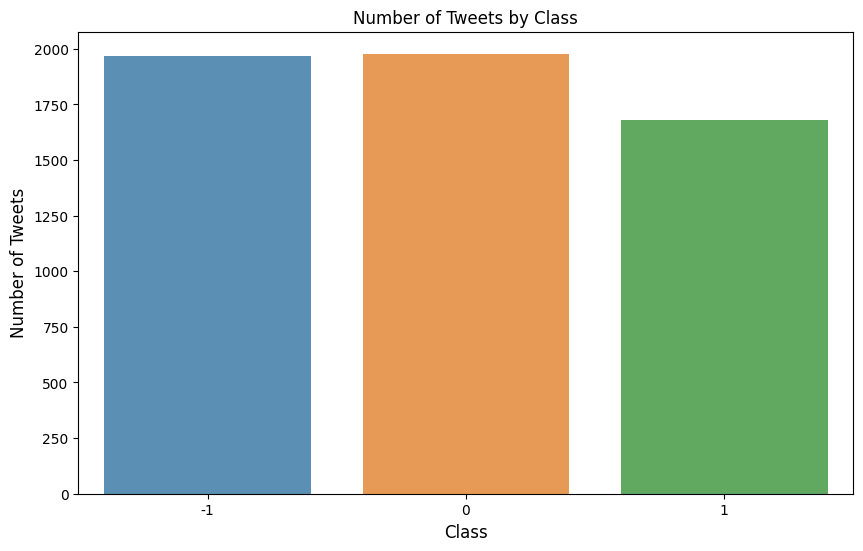

In [154]:
class_counts = obama_df['class'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index, y=class_counts.values, alpha=0.8)

plt.title('Number of Tweets by Class')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Class', fontsize=12)

plt.show()

In [155]:
# class_counts = obama_df['tweet'].value_counts()
# ax = obama_df.plot.bar(x='class', y=class_counts, rot=0)

Now, we can start working on the actual tweets. The first few steps that we need to perform are cleaning the text itself and tokenizing it.<br>
For that, we use 2 functions:

In [156]:
def clean(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)
    text = re.sub(r'www.[^ ]+', '', text)
    text = re.sub(r'[^a-z]', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text

regexp = RegexpTokenizer('\w+')

nltk.download('stopwords')

def tokenize(text):
    stop_words = stopwords.words('english')
    text = clean(text)
    text = regexp.tokenize(text)
    text = [w for w in text if w not in stop_words]
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utsav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The code cell below performs the task of going through our dataset, cleaning and tokenizing every tweet.

In [157]:
obama_df['tweet_token'] = obama_df['tweet'].apply(lambda stext: tokenize(str(stext)))

We then remove the words that are less than 2 characters, and appear less than 2 times, since those are most likely noise and would not contribute anything to our dataset.

In [158]:
#remove words with length less than 2
obama_df['tweet_string'] = obama_df['tweet_token'].apply(lambda x:' '.join([item for item in x if len(item)>2]))
#Find a frequency distribution, and remove words with frequency less than 1
all_words = ' '.join([text for text in obama_df['tweet_string']])
tokenized_obama_df = nltk.tokenize.word_tokenize(all_words)
fdist = FreqDist(tokenized_obama_df)
obama_df['tweet_string_fdist'] = obama_df['tweet_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] > 1 ]))

Now we have to perform the important task of Lemmatizing our dataset. To do this, we use `WordNetLemmatizer` with `Parts-Of-Speech tags`.

In [159]:
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatiser(text):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    wordnet_tagged = map(lambda x: (x[0], pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\utsav\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Applying this to our dataset:

In [160]:
obama_df['tweet'] = obama_df['tweet_string_fdist'].apply(lambda x: lemmatiser(x))
obama_df.head(5)

,tweet,class,tweet_token,tweet_string,tweet_string_fdist
1,wore cap barack obama signature look jason jou...,0,"[kirkpatrick, wore, baseball, cap, embroidered...",kirkpatrick wore baseball cap embroidered bara...,wore cap barack obama signature look jason jou...
3,obama debate cracker as cracker tonight,1,"[e, obama, e, debates, cracker, ass, cracker, ...",obama debates cracker ass cracker tonight tuned,obama debates cracker ass cracker tonight
5,miss point afraid understand big picture dont ...,0,"[youre, missing, point, im, afraid, understand...",youre missing point afraid understand bigger p...,missing point afraid understand bigger picture...
7,raise democrat leave party year ago never see ...,-1,"[raised, democrat, left, party, years, ago, li...",raised democrat left party years ago lifetime ...,raised democrat left party years ago never see...
8,obama camp afford low expectation tonight deba...,0,"[e, obama, camp, e, afford, lower, expectation...",obama camp afford lower expectations tonight d...,obama camp afford lower expectations tonight d...


We can drop the columns `tweet_token`, `tweet_string` and `tweet_string_fdist` now.<br>
We also remove the null values, to make sure that we do not have any empty records left after the previous steps.

In [161]:
obama_df = obama_df.drop(['tweet_token', 'tweet_string', 'tweet_string_fdist'], axis=1)
obama_df.dropna(inplace=True)
print(obama_df.shape)
obama_df.head(5)

(5625, 2)


,tweet,class
1,wore cap barack obama signature look jason jou...,0
3,obama debate cracker as cracker tonight,1
5,miss point afraid understand big picture dont ...,0
7,raise democrat leave party year ago never see ...,-1
8,obama camp afford low expectation tonight deba...,0


We can now take a look at the distribution of the classes in our dataset:

In [162]:
print(obama_df['class'].value_counts())

 0    1978
-1    1968
 1    1679
Name: class, dtype: int64


## Creating train and test data splits

Our data is now ready for processing. To train and test our models, we will perform a train-test-split of 80-20.

In [163]:
df_X = obama_df['tweet']
df_Y = obama_df['class']
X_train, X_test, y_train, y_test = train_test_split(df_X,df_Y,test_size=0.2,random_state = 1551)

## Vectorization

### TF-IDF Vectorization

We will use `TfidfVectorizer` from `sklearn`.

In [164]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2))
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

### Word2Vec

We will also try using `Word2Vec` from `gensim`.

In [165]:
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [166]:
#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

obama_df['clean_text_tok']=[nltk.word_tokenize(i) for i in obama_df['tweet']] 
model = Word2Vec(obama_df['clean_text_tok'],min_count=1) 
w2v = dict(zip(model.wv.index_to_key , model.wv.vectors))   
modelw = MeanEmbeddingVectorizer(w2v)

X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)
obama_df.drop(['clean_text_tok'], axis=1, inplace=True)

To make sure that the negative numbers produced by this do not trip up our models, we use `MinMaxScaler` to normalize the values between 0 and 1.

In [167]:
scaler = MinMaxScaler()
X_train_vectors_w2v = scaler.fit_transform(X_train_vectors_w2v)
X_test_vectors_w2v = scaler.transform(X_test_vectors_w2v)

Now, we are ready to create and test on our models.

## Supervised Learning:

Before we start running our models, to make things easier, we will create a dataframe to keep a track of our performance metrics.

In [168]:
performance = pd.DataFrame(columns=['Model','Vectorization','Accuracy', 'Precision', 'Recall', 'F1 Score'])

To make things even easier, I have written a small function to store our metrics in the dataframe.

In [169]:
def write_metrics(model_name,vector_name,test,predictions):
    global performance
    new_data = {'Model': model_name,
                'Vectorization': vector_name,
                'Accuracy': round(accuracy_score(test,predictions),4),
                'Precision': round(precision_score(test,predictions, average='weighted'),4),
                'Recall': round(recall_score(test,predictions, average='weighted'),4),
                'F1 Score': round(f1_score(test,predictions, average='weighted'),4)}
    performance = performance.append(new_data, ignore_index=True)

### Model 1: Logistic Regression

##### TF-IDF

In [170]:
lr_model_tfidf = LogisticRegression(solver='saga',C=5,penalty='l2',random_state=44) #4=57%
lr_model_tfidf.fit(X_train_vectors_tfidf, y_train)
lr_tfidf_y_pred = lr_model_tfidf.predict(X_test_vectors_tfidf)
print(classification_report(y_test,lr_tfidf_y_pred))
write_metrics('Logistic Regression','TF-IDF',y_test,lr_tfidf_y_pred)

              precision    recall  f1-score   support

          -1       0.60      0.61      0.61       428
           0       0.49      0.52      0.51       365
           1       0.62      0.57      0.59       332

    accuracy                           0.57      1125
   macro avg       0.57      0.57      0.57      1125
weighted avg       0.57      0.57      0.57      1125



C:\Users\utsav\AppData\Local\Temp\ipykernel_22920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


##### Word2Vec:

In [171]:
lr_model_w2v = LogisticRegression(solver='liblinear',C=10,penalty='l2',random_state=4) #4=57%
lr_model_w2v.fit(X_train_vectors_w2v, y_train)
lr_w2v_y_pred = lr_model_w2v.predict(X_test_vectors_w2v)
print(classification_report(y_test,lr_w2v_y_pred))
write_metrics('Logistic Regression','Word2Vec',y_test,lr_w2v_y_pred)

              precision    recall  f1-score   support

          -1       0.52      0.54      0.53       428
           0       0.43      0.49      0.46       365
           1       0.58      0.46      0.51       332

    accuracy                           0.50      1125
   macro avg       0.51      0.50      0.50      1125
weighted avg       0.51      0.50      0.50      1125



C:\Users\utsav\AppData\Local\Temp\ipykernel_22920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


### Model 2: Naive Bayes

##### TF-IDF:

In [172]:
nb_tfidf_model = MultinomialNB()
nb_tfidf_model.fit(X_train_vectors_tfidf, y_train)
nb_tfidf_y_pred = nb_tfidf_model.predict(X_test_vectors_tfidf)
print(classification_report(y_test,nb_tfidf_y_pred))
write_metrics('Naive Bayes','TF-IDF',y_test,nb_tfidf_y_pred)

              precision    recall  f1-score   support

          -1       0.60      0.65      0.63       428
           0       0.49      0.54      0.52       365
           1       0.67      0.53      0.59       332

    accuracy                           0.58      1125
   macro avg       0.59      0.58      0.58      1125
weighted avg       0.59      0.58      0.58      1125



C:\Users\utsav\AppData\Local\Temp\ipykernel_22920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


##### Word2Vec:

In [173]:
nb_w2v_model = MultinomialNB()
nb_w2v_model.fit(X_train_vectors_w2v, y_train)
nb_w2v_y_pred = nb_w2v_model.predict(X_test_vectors_w2v)
print(classification_report(y_test,nb_w2v_y_pred))
write_metrics('Naive Bayes','Word2Vec',y_test,nb_w2v_y_pred)

              precision    recall  f1-score   support

          -1       0.45      0.47      0.46       428
           0       0.32      0.25      0.28       365
           1       0.40      0.47      0.43       332

    accuracy                           0.40      1125
   macro avg       0.39      0.40      0.39      1125
weighted avg       0.39      0.40      0.39      1125



C:\Users\utsav\AppData\Local\Temp\ipykernel_22920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


### Model 3: SVM

##### TF-IDF:

In [174]:
svm_tfidf_model = svm.SVC(kernel='linear', random_state=1564)
svm_tfidf_model.fit(X_train_vectors_tfidf, y_train)
svm_tfidf_y_pred = svm_tfidf_model.predict(X_test_vectors_tfidf)
print(classification_report(y_test,svm_tfidf_y_pred))
write_metrics('SVM','TF-IDF',y_test,svm_tfidf_y_pred)

              precision    recall  f1-score   support

          -1       0.61      0.62      0.61       428
           0       0.50      0.53      0.51       365
           1       0.63      0.58      0.61       332

    accuracy                           0.58      1125
   macro avg       0.58      0.58      0.58      1125
weighted avg       0.58      0.58      0.58      1125



C:\Users\utsav\AppData\Local\Temp\ipykernel_22920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


##### Word2Vec:

In [175]:
svm_w2v_model = svm.SVC(kernel='linear', random_state=4)
svm_w2v_model.fit(X_train_vectors_w2v, y_train)
svm_w2v_y_pred = svm_w2v_model.predict(X_test_vectors_w2v)
print(classification_report(y_test,svm_w2v_y_pred))
write_metrics('SVM','Word2Vec',y_test,svm_w2v_y_pred)

              precision    recall  f1-score   support

          -1       0.51      0.52      0.52       428
           0       0.39      0.52      0.45       365
           1       0.60      0.36      0.45       332

    accuracy                           0.47      1125
   macro avg       0.50      0.47      0.47      1125
weighted avg       0.50      0.47      0.47      1125



C:\Users\utsav\AppData\Local\Temp\ipykernel_22920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


### Model 4: KNN

##### TF-IDF:

In [176]:
knn_tfidf = KNeighborsClassifier()#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}#use gridsearch to test all values for n_neighbors
knn_tfidf_gscv = GridSearchCV(knn_tfidf, param_grid, cv=5)#fit model to data
clf = knn_tfidf_gscv.fit(X_train_vectors_tfidf, y_train)
knn_tfidf_y_pred = clf.predict(X_test_vectors_tfidf)
print(classification_report(y_test,knn_tfidf_y_pred))
write_metrics('KNN','TF-IDF',y_test,knn_tfidf_y_pred)

              precision    recall  f1-score   support

          -1       0.67      0.32      0.43       428
           0       0.50      0.45      0.48       365
           1       0.43      0.77      0.55       332

    accuracy                           0.50      1125
   macro avg       0.53      0.51      0.49      1125
weighted avg       0.54      0.50      0.48      1125



C:\Users\utsav\AppData\Local\Temp\ipykernel_22920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


#### Word2Vec:

In [177]:
knn_w2v = KNeighborsClassifier()#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}#use gridsearch to test all values for n_neighbors
knn_w2v_gscv = GridSearchCV(knn_w2v, param_grid, cv=5)#fit model to data
clf_w2v = knn_w2v_gscv.fit(X_train_vectors_w2v, y_train)
knn_w2v_y_pred = clf_w2v.predict(X_test_vectors_w2v)
print(classification_report(y_test,knn_w2v_y_pred))
write_metrics('KNN','Word2Vec',y_test,knn_w2v_y_pred)

              precision    recall  f1-score   support

          -1       0.46      0.59      0.52       428
           0       0.36      0.37      0.37       365
           1       0.46      0.30      0.36       332

    accuracy                           0.43      1125
   macro avg       0.43      0.42      0.42      1125
weighted avg       0.43      0.43      0.42      1125



C:\Users\utsav\AppData\Local\Temp\ipykernel_22920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


In [178]:
performance.head(10)

,Model,Vectorization,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,TF-IDF,0.5698,0.5726,0.5698,0.5706
1,Logistic Regression,Word2Vec,0.5013,0.5096,0.5013,0.5026
2,Naive Bayes,TF-IDF,0.5804,0.5880,0.5804,0.5812
3,Naive Bayes,Word2Vec,0.3991,0.3921,0.3991,0.3929
4,SVM,TF-IDF,0.5787,0.5810,0.5787,0.5794
5,SVM,Word2Vec,0.4738,0.4980,0.4738,0.4742
6,KNN,TF-IDF,0.4951,0.5432,0.4951,0.4821
7,KNN,Word2Vec,0.4302,0.4302,0.4302,0.4224


### Model 5: Voting Classifier

From this performance data, we can see that Logistic Regression, Naive Bayes and SVM have performance that is very close. Therefore, I use a Voting Classifier to create a model that predicts based on the votes from all 3 of these.

In [179]:
estimator = [] 
estimator.append(('LR', LogisticRegression(solver='saga',C=5,penalty='l2',random_state=44))) 
estimator.append(('Naive Bayes', MultinomialNB())) 
estimator.append(('SVM', svm.SVC(kernel='linear', random_state=4, probability=True)))
voting = VotingClassifier(estimators = estimator, voting ='soft') 
voting.fit(X_train_vectors_tfidf, y_train) 
y_pred_vot = voting.predict(X_test_vectors_tfidf) 
print(classification_report(y_test,y_pred_vot))

              precision    recall  f1-score   support

          -1       0.61      0.63      0.62       428
           0       0.49      0.52      0.51       365
           1       0.62      0.57      0.59       332

    accuracy                           0.57      1125
   macro avg       0.58      0.57      0.57      1125
weighted avg       0.58      0.57      0.57      1125



## Semi-Supervised:

As we can see from the statistics, we achieve a 57% accuracy using our Voting classifier. But, can we improve things further?<br>
If we look back to the start of this notebook, we dropped all records that were not in the classes -1, 0 and 1.<br>
However, that means we lose out on 1,544 records that are labelled as class 2 (mixed). These tweets express both positive and negative opinions.<br>
In our problem statement, we are only concered with the classes -1, 0 and 1. 
So, what if we were to perform semi-supervised learning and treat these as unlabelled data?

In [180]:
obama_mixed = obama[obama['class'].isin(['2',2])].copy(deep=True)
obama_mixed['class']=obama_mixed['class'].astype(int)
obama_mixed['tweet_token'] = obama_mixed['tweet'].apply(lambda stext: tokenize(str(stext)))

#remove words with length less than 2
obama_mixed['tweet_string'] = obama_mixed['tweet_token'].apply(lambda x:' '.join([item for item in x if len(item)>2]))

all_words = ' '.join([text for text in obama_mixed['tweet_string']])
tokenized_obama_mixed = nltk.tokenize.word_tokenize(all_words)
fdist = FreqDist(tokenized_obama_mixed)
obama_mixed['tweet_string_fdist'] = obama_mixed['tweet_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] > 1 ]))

obama_mixed['tweet'] = obama_mixed['tweet_string_fdist'].apply(lambda x: lemmatiser(x))
obama_mixed.head(5)
obama_mixed = obama_mixed.drop(['tweet_token', 'tweet_string', 'tweet_string_fdist'], axis=1)
obama_mixed.dropna(inplace=True)
obama_mixed.drop(['class'], axis=1)
print(obama_mixed.shape)
obama_mixed.head(5)

(1544, 2)


,tweet,class
2,question romney obama child mitt punch five ob...,2
4,slate blame obama four death libya blame bush ...,2
6,mitt romney make money barack obama make money...,2
9,tonight debate game feel pres obama call romne...,2
12,guy rather obama critique romney tax plan,2


Creating TF-IDF vectors of these records,

In [181]:
mixed_vectors_tfidf = tfidf_vectorizer.transform(obama_mixed['tweet'])

We predict the classes for these records.

In [182]:
mixed_y_pred = voting.predict(mixed_vectors_tfidf)
print(mixed_y_pred)

[ 0 -1  0 ...  1  0  1]


We add these classes to our `obama_mixed` dataframe,

In [183]:
obama_mixed['class'] = mixed_y_pred
obama_mixed.head()

,tweet,class
2,question romney obama child mitt punch five ob...,0
4,slate blame obama four death libya blame bush ...,-1
6,mitt romney make money barack obama make money...,0
9,tonight debate game feel pres obama call romne...,0
12,guy rather obama critique romney tax plan,0


And merge these records with our existing dataframe `obama_df`,

In [184]:
obama_merged = obama_df.merge(obama_mixed, how='outer')
obama_merged.shape

(7168, 2)

Now, we retrain our Voting Classifier on this new dataset:

In [185]:
ss_df_X = obama_merged['tweet']
ss_df_Y = obama_merged['class']
ss_X_train, ss_X_test, ss_y_train, ss_y_test = train_test_split(ss_df_X,ss_df_Y,test_size=0.2,random_state = 1551)

In [186]:
ss_X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(ss_X_train)
ss_X_test_vectors_tfidf = tfidf_vectorizer.transform(ss_X_test)

In [187]:
estimator_ss = [] 
estimator_ss.append(('LR', LogisticRegression(solver='saga',C=5,penalty='l2',random_state=44))) 
estimator_ss.append(('Naive Bayes', MultinomialNB())) 
estimator_ss.append(('SVM', svm.SVC(kernel='linear', random_state=4, probability=True))) 
voting.fit(ss_X_train_vectors_tfidf, ss_y_train) 
y_pred_vot_ss = voting.predict(ss_X_test_vectors_tfidf) 
print(classification_report(ss_y_test,y_pred_vot_ss))

              precision    recall  f1-score   support

          -1       0.67      0.62      0.64       463
           0       0.65      0.74      0.69       580
           1       0.71      0.63      0.67       391

    accuracy                           0.67      1434
   macro avg       0.68      0.66      0.67      1434
weighted avg       0.67      0.67      0.67      1434



This achieves 67% accuracy for the model.

## Sample Data

Now that the model is ready, we can load, clean and tokenize the sample data excel.

In [188]:
#data loading
sample_data = pd.ExcelFile(sample_data_excel)
sample_obama = pd.read_excel(sample_data, sample_data_sheet)
#print(sample_obama.shape)
#print(sample_obama.head(5))
if(len(sample_obama.columns) == 6):
    sample_obama = sample_obama[1:]
    sample_obama = sample_obama.drop(['Unnamed: 0', 'date', 'time', 'Unnamed: 5'], axis=1)
    sample_obama = sample_obama.rename(columns={'Unnamed: 4': 'class', 'Anootated tweet': 'tweet'})
    sample_obama = sample_obama[sample_obama['class'].isin(['-1', '0', '1',-1,0,1])]
    sample_obama['class']=sample_obama['class'].astype(int)
    #create a copy to use for printing to output file
    output_data = sample_obama.copy(deep=True)
    sample_obama['tweet_token'] = sample_obama['tweet'].apply(lambda stext: tokenize(str(stext)))
    #remove words with length less than 2
    sample_obama['tweet_string'] = sample_obama['tweet_token'].apply(lambda x:' '.join([item for item in x if len(item)>2]))
    #Find a frequency distribution, and remove words with frequency less than 1
    all_words = ' '.join([text for text in sample_obama['tweet_string']])
    tokenized_sample_obama = nltk.tokenize.word_tokenize(all_words)
    fdist = FreqDist(tokenized_sample_obama)
    sample_obama['tweet_string_fdist'] = sample_obama['tweet_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] > 1 ]))
    sample_obama['tweet'] = sample_obama['tweet_string_fdist'].apply(lambda x: lemmatiser(x))
    #sample_obama.head(5)
    sample_obama = sample_obama.drop(['tweet_token', 'tweet_string', 'tweet_string_fdist'], axis=1)
    sample_obama.dropna(inplace=True)
    #print(sample_obama.shape)
    #sample_obama.head(5)
    sample_df_X = sample_obama['tweet']
    sample_df_Y = sample_obama['class']
elif(len(sample_obama.columns) == 2):
    sample_obama = pd.read_excel(sample_data, sample_data_sheet,header=None)
    sample_obama.drop(sample_obama.columns[0], axis=1, inplace=True)
    sample_obama.columns = ['tweet']
    output_data = sample_obama.copy(deep=True)
    sample_obama['tweet_token'] = sample_obama['tweet'].apply(lambda stext: tokenize(str(stext)))
    #remove words with length less than 2
    sample_obama['tweet_string'] = sample_obama['tweet_token'].apply(lambda x:' '.join([item for item in x if len(item)>2]))
    #Find a frequency distribution, and remove words with frequency less than 1
    all_words = ' '.join([text for text in sample_obama['tweet_string']])
    tokenized_sample_obama = nltk.tokenize.word_tokenize(all_words)
    fdist = FreqDist(tokenized_sample_obama)
    sample_obama['tweet_string_fdist'] = sample_obama['tweet_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] > 1 ]))
    sample_obama['tweet'] = sample_obama['tweet_string_fdist'].apply(lambda x: lemmatiser(x))
    #sample_obama.head(5)
    sample_obama = sample_obama.drop(['tweet_token', 'tweet_string', 'tweet_string_fdist'], axis=1)
    sample_obama.dropna(inplace=True)
    #print(sample_obama.shape)
    #sample_obama.head(5)
    sample_df_X = sample_obama['tweet']
else:
    print("Invalid columns - check the excel file")
X_sample_vectors = tfidf_vectorizer.transform(sample_df_X)
print(sample_obama.shape)
sample_obama.head(5)

(5625, 2)


,tweet,class
1,wore cap barack obama signature look jason jou...,0
3,obama debate cracker as cracker tonight,1
5,miss point afraid understand big picture dont ...,0
7,raise democrat leave party year ago never see ...,-1
8,obama camp afford low expectation tonight deba...,0


In [189]:
# #data loading
# sample_data = pd.ExcelFile(sample_data_excel)
# sample_obama = pd.read_excel(sample_data, sample_data_sheet)
# sample_obama = sample_obama[1:]
# sample_obama = sample_obama.drop(['Unnamed: 0', 'date', 'time', 'Unnamed: 5'], axis=1)
# sample_obama = sample_obama.rename(columns={'Unnamed: 4': 'class', 'Anootated tweet': 'tweet'})
# sample_obama.head(5)
# sample_obama = sample_obama[sample_obama['class'].isin(['-1', '0', '1',-1,0,1])]
# sample_obama['class']=sample_obama['class'].astype(int)
# #create a copy to use for printing to output file
# output_data = sample_obama.copy(deep=True)
# sample_obama['tweet_token'] = sample_obama['tweet'].apply(lambda stext: tokenize(str(stext)))
# #remove words with length less than 2
# sample_obama['tweet_string'] = sample_obama['tweet_token'].apply(lambda x:' '.join([item for item in x if len(item)>2]))
# #Find a frequency distribution, and remove words with frequency less than 1
# all_words = ' '.join([text for text in sample_obama['tweet_string']])
# tokenized_sample_obama = nltk.tokenize.word_tokenize(all_words)
# fdist = FreqDist(tokenized_sample_obama)
# sample_obama['tweet_string_fdist'] = sample_obama['tweet_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] > 1 ]))
# sample_obama['tweet'] = sample_obama['tweet_string_fdist'].apply(lambda x: lemmatiser(x))
# sample_obama.head(5)
# sample_obama = sample_obama.drop(['tweet_token', 'tweet_string', 'tweet_string_fdist'], axis=1)
# sample_obama.dropna(inplace=True)
# print(sample_obama.shape)
# sample_obama.head(5)
# sample_df_X = sample_obama['tweet']
# sample_df_Y = sample_obama['class']
# X_sample_vectors = tfidf_vectorizer.transform(sample_df_X)

Predicting for our sample test data:

In [190]:
sample_y_pred = voting.predict(X_sample_vectors)
# print(classification_report(sample_df_Y,sample_y_pred))

Finally, we write our predicted classes to an excel sheet.

In [ ]:
output_data['Predicted class'] = sample_y_pred
output_data.to_excel('C:/Users/utsav/OneDrive/UIC/Fall_2023/CS_583/Project/output_obama.xlsx', index=False)

Resources:<br>
https://www.kirenz.com/post/2021-12-11-text-mining-and-sentiment-analysis-with-nltk-and-pandas-in-python/text-mining-and-sentiment-analysis-with-nltk-and-pandas-in-python/ <br>
https://medium.com/@qacbustamante/natural-language-processing-using-python-part-1-958d4ea1846e <br>
https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/ <br>